# Introduction
The Los Angeles Police Department(LAPD) is responsible for the protection and safeguard of the City of Los Angeles. While the LAPD has been attempting to reduce crime each year, it is a difficult goal to achieve due to growing population and only fewer than 10000 active officers in the department. However, an analysis of the LAPD historical crime record can provide a better view of crime trends and allow the LAPD to allocate resources accordingly.

In this post the analysis will be conducted using Jupyter Notebook and the primary dataset contains information regarding  arrest incidents conducted by LAPD in the year of 2015.


# The Dataset
The dataset used in this analysis belongs to Los Angeles Police Department. Below is the link to the dataset that will be used:

[Open Data ARR 2015](https://data.lacity.org/A-Safe-City/Open-Data-ARR-2015/d4vt-ypi8/data) (Arrests made in the City of Los Angeles)

There are also other datasets with information such as crime reports and call for services received by LAPD, but these datasets do not contain crucial elements that are needed for the analysis.

# Background Information
* The City of Los Angeles is divided into 21 areas by LAPD
* Each area consists of numerous reporting districts(RD)
* There are 1135 reporting districts, a unique number ranging from 101 to 2199 is assigned to each reporting district

# Examine the dataset
Now begin loading the dataset and some packages into Jupyter Notebook. In this case the dataset will be called "Arrest"

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt

os.chdir('C:\\Users\\Andy\\Desktop\\LAPD')
data = {}

for file in glob.glob("*.csv"):
    df = pd.read_csv(file)
    data[file.replace(".csv", "")] = df
    
Arrest = data['LAPD_Arrest'] 

Use the head function to get a brief idea of how the data looks like

In [2]:
Arrest.head()

,ARST DATE,TIME,RPT_ID,AREA,AREA_DESC,RD,AGE,SEX_CD,DESCENT_CD,CHRG_GRP_CD,GRP_DESC,ARST_TYP_CD,CHARGE,CHRG_DESC,LOCATION,CRSST,Location 1
0,4/15/2015 0:00,2015.0,4299618,1,Central,105,0,F,H,NaN,NaN,D,300(B)WI,NaN,BISHOPS RD,PASADENA FY,"(0.0000, 0.0000)"
1,2/6/2015 0:00,910.0,4232636,1,Central,123,0,F,H,26.0,Non-Criminal Detention,D,300(J)WI,PROT CUST/ENDANGER SIBLINGS/UNFIT HOME,900 S DUNCAN ST,NaN,"(34.1861, -118.5435)"
2,8/20/2015 0:00,1600.0,4420207,1,Central,156,0,M,B,NaN,NaN,D,300(B)WIC,NaN,8TH ST,TOWNE AV,"(34.0371, -118.2475)"
3,8/14/2015 0:00,1030.0,4415119,1,Central,158,0,M,C,26.0,Non-Criminal Detention,D,300(J)WI,PROT CUST/ENDANGER SIBLINGS/UNFIT HOME,6TH,SAN PEDRO,"(34.0423, -118.2452)"
4,3/20/2015 0:00,1340.0,4273819,2,Rampart,231,0,F,B,NaN,NaN,O,300(B)WIC,NaN,100 N OCCIDENTAL BL,NaN,"(34.0707, -118.2795)"


After examining each column and searching for essential information online, the followings are the definitions for each column:
* "ARST DATE" is the date when each arrest occurred
* "TIME" is recorded in 24-hour time, ranging from 0 to 2400
* "RPT_ID" is the unique identifier for each arrest incident
* "AREA" is the value of area where each arrest occurred, ranging from 1 to 21
* "RD" is the value of reporting district, ranging from 101 to 2199
* "AGE" is the age of the person who was arrested
* "SEX_CD" is the gender of the person who was arrested
* "DESCENT_CD" is the ethnicity of the person who was arrested
* "CHRG_GRP_CD" is the code assigned to a specific crime
* "GRP_DESC" is the description of the crime code
* "ARST_TYP_CD" is the category assigned to the crime
* "CHARGE" is the penal code, or criminal code
* "CHRG_DESC" is the description of the penal code
* "LOCATION", "CRSST" are the street name information of each arrest
* "Location 1" is the latitude and longitude where the arrest occurred

# Cleaning the dataset
There are total 126854 entries in the dataset. Entries with reporting district(RD) that is not between 101 and 2199 should be removed.

In [3]:
Arrest = Arrest[(Arrest['RD'] >= 101) & (Arrest['RD'] <= 2199)]

Fortunately, there is no null entires in "AGE", and the only columns containing null entries are "CHRG_GRP_CD",  "CHRG_DESC" and "TIME". To deal with null entries in numerical data such as age or height, it is sufficient to replace them with average age of that specific area, given that the number of null entries is not very large. Predictive algorithms such as linear regression and random forest can also be used to fill the null entries, simply use the portion of dataset containing valid age information to train the model for prediction. 

According to Shouse California Law Group, minors under 18 generally go to juvenile court. But for certain crimes minors 14 and up must be tried as adults, so the analysis will include only those who are 14 or older. Removing entries with age below 14 will not be problematic since they represent less than 1% of the entire dataset.

In [4]:
len(Arrest[Arrest['AGE'] < 14])/len(Arrest)

0.009973037322022675

In [5]:
Arrest = Arrest[Arrest['AGE'] >= 14]
Arrest.reset_index(drop=True, inplace=True)

Now move on to "TIME", first fill the null entries with the mean value since there are only a few of them. Then convert all the entries into integer hours for later uses.

In [6]:
for i in range(0, len(Arrest)):
    if(Arrest['TIME'][i] == 2400):
        Arrest.set_value(i, 'TIME', 1)

np.unique(Arrest['TIME'].isnull(), return_counts = True)
Arrest['TIME'] = Arrest['TIME'].fillna(Arrest['TIME'].mean())
Arrest['TIME'] = Arrest['TIME']/100
Arrest['TIME'] = Arrest['TIME'].apply(np.floor)
Arrest['TIME'] = Arrest['TIME'].astype(int);

Next convert the date in all the entries into a new column "DayOfWeek"(0 = Monday, 1 = Tuesday, 2 = Wednesday and so on).

In [7]:
#Convert dates into days of week
#0 Mon, 1 Tues, 2 Wed
day = pd.DataFrame(Arrest['ARST DATE'])
day['ARST DATE'] = pd.to_datetime(day['ARST DATE'])
day['ARST DATE'] = day['ARST DATE'].dt.dayofweek
DOW = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6'}
day['ARST DATE'] = day['ARST DATE'].apply(lambda x: DOW[x])
Arrest['DayOfWeek'] = day['ARST DATE']

Change the date format into Pandas format, so it is easier to use later

In [8]:
#Convert date into pd format and sort
Arrest['ARST DATE'] = pd.to_datetime(Arrest['ARST DATE'])
Arrest.sort_values(by='ARST DATE', inplace = True)

The unique function from Numpy shows that there are a total 16 of different ethnicity codes that can be assigned to a person. Some codes have extreme low counts and it would be a good idea to group the codes into 5 big categories:

A = Asian

B = Black

H = Hispanic

O = Other

W = White

In [9]:
np.unique(Arrest['DESCENT_CD'], return_counts = True)

(array(['A', 'B', 'C', 'F', 'G', 'H', 'I', 'J', 'K', 'O', 'P', 'S', 'V',
        'W', 'X', 'Z'], dtype=object),
 array([  616, 36056,    83,    86,     2, 58036,    20,    17,    92,
         6725,    19,     2,     1, 23811,    10,     1], dtype=int64))

According to the standards of National Center for Education Statistics(NCES) and the guidelines for definitions of ethnicity and race by Department of Education, the grouping is decided as follows:

    "C" = Cuban = "H" (Could also be Chinese)

    "F" = Filipinos = "A"

    "G" = Guamanian = "O"

    "I" = Indian = "A"

    "J" = Japanese = "A"

    "K" = Korean = "A"

    "P" = Pakistanis = "A"

    "S" = Southeast Asia = "A"

    "V" = Vietnamese = "A"

    "X", "Z" = "O"

The identification is not 100% accurate but should be sufficient.

In [10]:
Asian = ['F', 'I', 'J', 'K', 'P', 'S', 'V']
Hispanic = "C"
Other = ['G', 'X', 'Z']
for i in range(0, len(Arrest)):
    if(Arrest['DESCENT_CD'][i] in Asian):
        Arrest.set_value(i, 'DESCENT_CD', "A")
        
    elif(Arrest['DESCENT_CD'][i] == Hispanic):
        Arrest.set_value(i, 'DESCENT_CD', "H")
        
    elif(Arrest['DESCENT_CD'][i] in Other):
        Arrest.set_value(i, 'DESCENT_CD', "O")

The Location 1 columns represents the latitude and longitude where each incident takes place. There are approximately 5% of the entries are missing in this column, and these missing values are entered as (0, 0) or (0.0000, 0.0000).

In [11]:
Missing_Loc = np.unique(Arrest['Location 1'], return_counts = True)[1]
(Missing_Loc[0] + Missing_Loc[1]) / len(Arrest['Location 1'])

0.053401498682083499

There was an attempt to use Python packages such as Geopy and other geocoding API to reverse geocoding the latitude and longitude in "Location 1" into corresponding zip code. However, with 20537 unique latitude and longitude combinations to reverse geocoding, it would take days given no network error to finish the conversion due to the query limit on the Geopy package and web API. It is unfortunate but the columns containing geographical information will not be utilized.

It would be a good idea to separate incidents without crime code and create two different datasets, since it is not certain how crime code data will affect the analysis. The new dataframe will be named Arrest_MissingCrime.

In [12]:
Arrest_MissingCrime = Arrest[Arrest['CHRG_GRP_CD'].isnull()]
Arrest.drop(Arrest.index[Arrest_MissingCrime.index], inplace = True)
Arrest.reset_index(drop=True, inplace=True)
Arrest_MissingCrime.reset_index(drop=True, inplace=True)

# Age vs Crime

The describe() function returns some summary statistics for "AGE". The average age of the entire dataset is 34.85, median is 32, and standard deviation is 13.344523. From the quantitle information it can be concluded that half of the crimes are committed by people who are between 24 and 45 years old. The median age in this dataset is reasonably close to the median age of 35 of the overall population provided by Census Reporter

In [13]:
Arrest['AGE'].describe()

count    112727.000000
mean         34.859643
std          13.320318
min          14.000000
25%          24.000000
50%          32.000000
75%          45.000000
max          96.000000
Name: AGE, dtype: float64

With the above information, it is then possible to compute the coefficient of variation(CV).

In [14]:
Arrest['AGE'].std()/Arrest['AGE'].mean()

0.3821128499251696

A result of 0.382 indicates relatively low variation in "AGE".

Since the age data is obviously a set of continuous data, histograms can be helpful to identify the underlying frequency distribution. One thing to note is that both histograms appear to be right-skewed and have a unimodal distribution, where the data increase to reach a single peak then start decreasing.

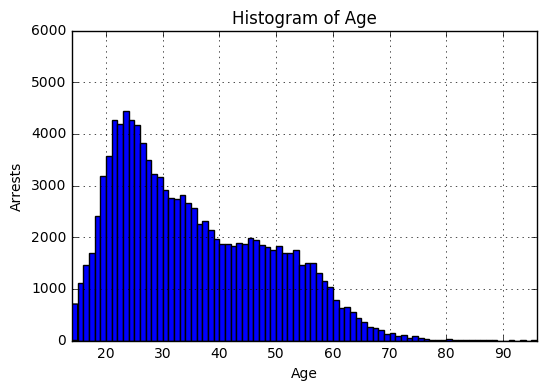

In [15]:
plt.hist(Arrest['AGE'], bins = 82)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Arrests')
plt.axis([14,96,0,6000])
plt.grid(True)
plt.show()

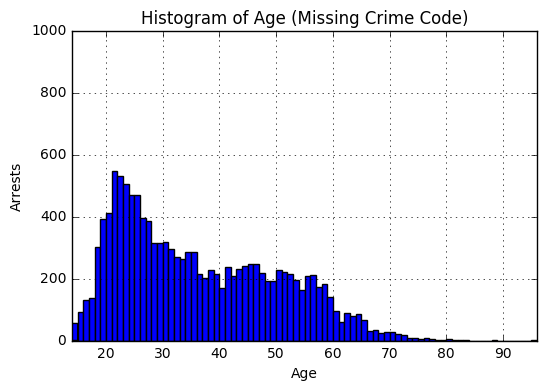

In [16]:
plt.hist(Arrest_MissingCrime['AGE'], bins = 82)
plt.title('Histogram of Age (Missing Crime Code)')
plt.xlabel('Age')
plt.ylabel('Arrests')
plt.axis([14,96,0,1000])
plt.grid(True)
plt.show()

The plot below shows that Area 1 and Area 8 have much higher average age, with an average age of 42 from Area 1 being the highest among all areas. Areas after and including 17 all have lower average age comparing with all other areas except Area 6.

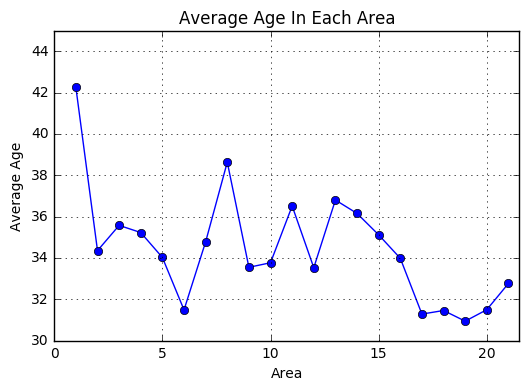

In [17]:
AvgAge_21 = []
AvgAge_21.append(None)
for i in range(1,22):
    a = Arrest[Arrest['AREA'] == i]
    avg = a['AGE'].mean()
    AvgAge_21.append(avg)
    
plt.title('Average Age In Each Area')
plt.plot(AvgAge_21, '-o')
plt.xlabel('Area')
plt.ylabel('Average Age')
plt.axis([0,21.5,30,45])
plt.grid(True)
plt.show()

## Five Categories of Crimes
The criminal systems in most states divide crimes into several categories, usually depending on how serious the crimes are. This categorization allows the court to determine how to treat each particular case. In this dataset, there are five main categories that a crime can be assigned into and the categoization of each arrest is indicated in "ARST_TYP_CD".

The five categories are defined as the following:

| Letter        | Category      | 
| ------------- |:-------------:|
| D             | Detention     |
| F             | Felony        | 
| I             | Illegal       |
| M             | Misdemeanor   |
| O             | Other         |

The bar chart below provides an overview on the counts of each category. Most of the crimes are either Felony or Misdemeanor, which are considered to be much more serious. Detention only applies to Non-criminal Detention and Pre-Delinquency, that is why the number of counts is extremely low.

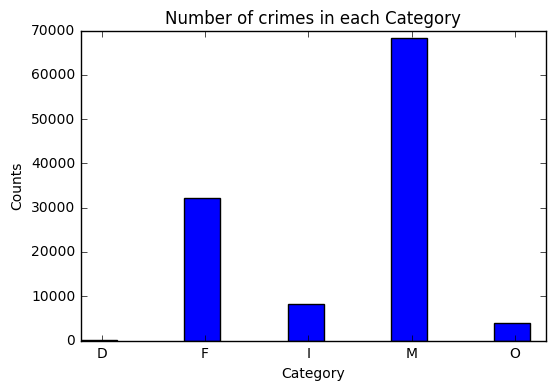

In [18]:
a = np.unique(Arrest['ARST_TYP_CD'], return_counts = True)
N = 5
index = np.arange(N)
plt.bar(index, a[1], 0.35)
plt.title('Number of crimes in each Category')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.xticks(index + 0.2, a[0])
plt.show()

## Types of Crime
Each crime is assigned a charge code("CHRG_GRP_CD") ranging from 1 to 27 with a category and description. Entries with no crime code have already been removed while cleaning the dataset, and the calculation below shows that about 11.4% of arrests were made without specific crime code.

In [19]:
len(Arrest_MissingCrime) / len(Arrest)

0.11399221127147888

There are also a few entries with crime code 29 and no description, these entries will be excluded from this point on. There are still 101149 entries in the dataset.

In [20]:
Arrest = Arrest[Arrest['CHRG_GRP_CD'].isin(range(1,28))]
Arrest.reset_index(drop=True, inplace=True)
len(Arrest)

101149

Among the 101149 arrest incidents in 2015, approximately 20% of them are Miscellaneous Other Violations. Each incident can only have one crime type. The least frequent crimes are Federal Offenses, Non-criminal Detention, Gambling, Homicide, Rape, and Disturbing the Peace. The most frequent ones are Miscellaneous Other Violations, Driving Under Influence, and Narcotic Drug Laws.

In [21]:
import plotly as py
py.tools.set_credentials_file(username='ayl019', api_key='tojGGHbVdFnhLso1P6vn')
import plotly.plotly as py
from plotly.tools import FigureFactory as FF

CrimeTable = pd.DataFrame(columns = ['Charge Code', 'Description' , 'Abbreviation', 'Frequency', 'Proportion'])
Frequency = np.asarray(Arrest.groupby(by = ['CHRG_GRP_CD','GRP_DESC'])['RPT_ID'].nunique())

Abbr = ['TOTAL', 'HOM', 'RAPE', 'ROB','AGG','BURG','LARY','VT','OA','FC','FE','RSP','WEAP','PROST','SEX',
        'AFC','NDL','LL','DRNK','DP','DC','GAMB','DUI','MTV','MOV','FO','NON', 'PRE']

for i in range(0, 27):
    Desc = Arrest[Arrest['CHRG_GRP_CD'] == (i+1)]['GRP_DESC']
    Desc = np.asarray(Desc)[0]
    Prop = (Frequency[i] / sum(Frequency)).round(4)
    CrimeTable.loc[i] = [(i+1),Desc, Abbr[i+1],Frequency[i], Prop]

CrimeTable['Charge Code'] = CrimeTable['Charge Code'].astype(int)
CrimeTable['Frequency'] = CrimeTable['Frequency'].astype(int)
CrimeTable.loc[28] = [28, "Total", Abbr[0], sum(CrimeTable['Frequency']), sum(CrimeTable['Proportion']).round(1)]

table_1 = FF.create_table(CrimeTable)
py.iplot(table_1, filename='pandas_table')

Below is a barchart on the number of counts for each crime code.

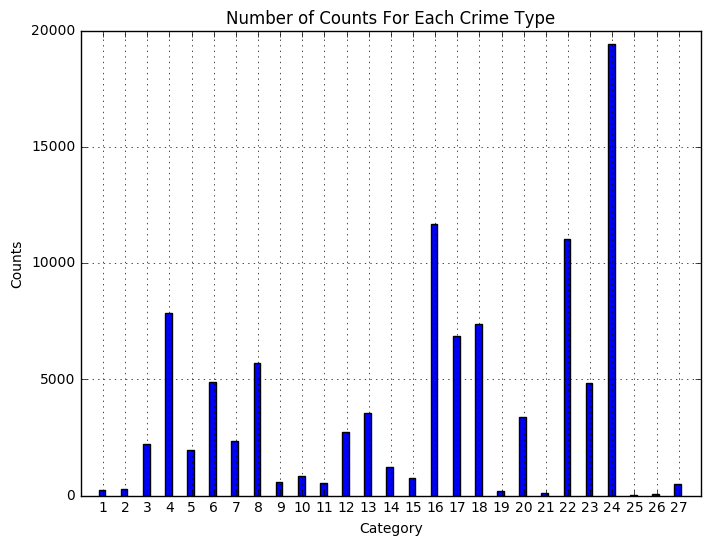

In [22]:
a = np.unique(Arrest['CHRG_GRP_CD'], return_counts = True)
plt.figure(figsize=(8,6))
plt.bar(a[0]-0.2, a[1], 0.3)
plt.title('Number of Counts For Each Crime Type')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.xticks(a[0])
plt.grid(True)
plt.axis([0,28,0,20000])
plt.show()

Now it is possible to examine the trends of each crime type in City of Los Angeles over the year by fitting a linear regression model. To do so it would require a new dataframe containing 365 rows(representing 365 days) with counts of each crime type and  a total count of crimes in each day. A new column "DayOfWeek" is added for the other part of the analysis and the new dataframe will be named "LR".

In [23]:
Date = np.unique(Arrest['ARST DATE'])
LR = pd.DataFrame(columns = ["Date", "Day", "DayOfWeek"] + Abbr)
LR['Date'] = np.unique(Arrest['ARST DATE'])
LR['Day'] = range(1,366)
LR['TOTAL'] = np.asarray(Arrest.groupby(by = ['ARST DATE'])['RPT_ID'].nunique())
DayOfWeek = []

for i in range(1,28):
    Col = []
    a = Arrest[Arrest['CHRG_GRP_CD'] == i]
    for j in range(0, len(Date)):
        b = a[a['ARST DATE'] == Date[j]]
        Col.append(len(b))
    LR[Abbr[i]] = Col

for i in range(0,365):
    DOW = Arrest[Arrest['ARST DATE'] == Date[i]]
    DayOfWeek.append(DOW['DayOfWeek'].iloc[0]) 

LR['DayOfWeek'] = pd.to_numeric(DayOfWeek)          
LR.head()

,Date,Day,DayOfWeek,TOTAL,HOM,RAPE,ROB,AGG,BURG,LARY,...,DRNK,DP,DC,GAMB,DUI,MTV,MOV,FO,NON,PRE
0,2015-01-01,1,3,283,0,0,5,22,2,6,...,16,1,1,0,61,17,59,0,0,0
1,2015-01-02,2,4,223,0,0,3,17,3,13,...,24,0,4,0,23,14,45,1,0,0
2,2015-01-03,3,5,251,0,0,5,19,2,6,...,17,0,5,0,27,8,39,0,0,1
3,2015-01-04,4,6,217,0,1,3,17,1,13,...,20,1,3,0,32,8,35,1,0,0
4,2015-01-05,5,0,231,4,1,1,19,0,12,...,7,0,9,0,20,12,46,0,0,0


Below is the summary of the linear regression model estimating crimes per day over the year for each crime type. It can be seen that most crime types(22 out of 27) see a decrease over the year. Most of the high frequency crime types decrease by a significant number by the end of the year, such as a decrease of 50% for Drunkeness, from 27 crimes per day to 13 crimes per day by the end of year. Miscellaneous Other Violations also has a noticeable decrease of 35%, from 64 crimes per day to 42 crimes per day. Crimes with low frequency see a much smaller decrease over the year. For example, the largest decrease of 84.3% is from Pre-Delinquency, but the decrease constitutes only 2 crimes per day by end of the year.

On the other hand, the linear model suggests that Aggravated Assault, Vehicle Theft, Other Assaults, Against Family/Child, and Disorderly Conduct increase over the year. The most noticeable increase in crime is Disorderly Conduct with an increase of 66%, from 7 crimes per day to 12 crimes per day by the end of year. Other Assaults also see an increase of 23%, from 14 crimes per day to 17 crimes per day.

In [24]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
Crime_Linear = pd.DataFrame(columns = ['Crimes', 'Intercept', 'Day'])
Crime_Linear['Crimes'] = Abbr

for i in range(0,28):
    result = smf.ols(formula = Abbr[i] + " ~ Day", data= LR).fit()
    Crime_Linear.set_value(i, 'Intercept', result.params[0].round(6))
    Crime_Linear.set_value(i, 'Day', result.params[1].round(6))

table_2 = FF.create_table(Crime_Linear)
py.iplot(table_2, filename='pandas_table')

In the case of linear regression model, it is essential to check the residual plot to validate the model. It can be seen from the residual plot that the points are randomly dispersed around the horizontal axis, indicating the linear model is appropriate for the data.

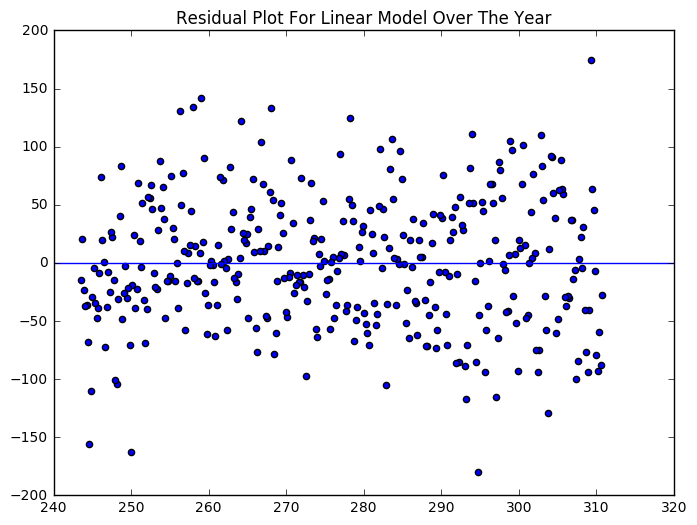

In [25]:
model = smf.glm(formula = "TOTAL ~ Day", data= LR).fit()
res = pd.DataFrame(columns = ['residual', 'fitted'])
res['residual'] = LR['TOTAL'] - model.fittedvalues
res['fitted'] = model.fittedvalues

plt.figure(figsize=(8,6))
plt.axhline()
plt.title("Residual Plot For Linear Model Over The Year")
plt.scatter(x=res['fitted'], y=res['residual'])
plt.show()

The linear regression model is used for simplicity and exploratory purposes. For estimating crimes per day over the year, a Poisson model should be more appropriate. The Poisson regression assumes the response variable, in this case the crime counts per day, has a Poisson distribution.

The table below is constructed with a Poisson regression model. It also suggests an increase in Aggravated Assault, Vehicle Theft, Other Assaults, Against Family/Child, and Disorderly Conduct while all other crime types see a decrease over the year. 

In [26]:
Crime_GLM = pd.DataFrame(columns = ['Crimes', 'Intercept', 'Day'])
Crime_GLM['Crimes'] = Abbr

for i in range(0,28):
    result = smf.glm(formula = Abbr[i] + " ~ Day", data= LR, family = sm.families.Poisson()).fit()
    Crime_GLM.set_value(i, 'Intercept', result.params[0].round(6))
    Crime_GLM.set_value(i, 'Day', result.params[1].round(6))

table_3 = FF.create_table(Crime_GLM)
py.iplot(table_3, filename='pandas_table')

Now consider using day of the week to estimate counts for each crime type, so it becomes the problem of dealing with more than two categorical predictors/features. To represent day of the week, six dummy variables are sufficient to capture all the necessary information(Generally k-1 dummy variables are needed for k predictors/features). Any row with a value of 0(False) in the six dummy columns will be Sunday.

In [27]:
DayCol = ['MON', 'TUES', 'WED', 'THURS', 'FRI', 'SAT']
for i in range(0,6):
    Col = []
    for j in range(0, len(Date)):
        if(LR['DayOfWeek'][j] == i):
            Col.append(1)
        else:
            Col.append(0)
    LR[DayCol[i]] = Col
    
LR.head()

,Date,Day,DayOfWeek,TOTAL,HOM,RAPE,ROB,AGG,BURG,LARY,...,MOV,FO,NON,PRE,MON,TUES,WED,THURS,FRI,SAT
0,2015-01-01,1,3,283,0,0,5,22,2,6,...,59,0,0,0,0,0,0,1,0,0
1,2015-01-02,2,4,223,0,0,3,17,3,13,...,45,1,0,0,0,0,0,0,1,0
2,2015-01-03,3,5,251,0,0,5,19,2,6,...,39,0,0,1,0,0,0,0,0,1
3,2015-01-04,4,6,217,0,1,3,17,1,13,...,35,1,0,0,0,0,0,0,0,0
4,2015-01-05,5,0,231,4,1,1,19,0,12,...,46,0,0,0,1,0,0,0,0,0


A linear model is constructed for each crime type using day of the week, the values from "MON to "SAT" basically represent the change relative to Sunday for the corresponding crime type. Generally speaking, Sundays see fewer total crimes in contrast with other days(Except Monday) but also have the highest counts of Aggravated Assaults. Thursdays see the most crime counts and are estimated to have the highest number of Homicide, Robbery, Receive Stolen Property, Weapon (carry/poss), Drunkness, and Miscellaneous Other Violations.

As for weekend, Sundays and Saturdays see higher counts of Other Assaults, Disturbing the Peace, and Driving Under Influence than weekday. Since residual plot was shown for the previous linear model, the R-squared will be added to the table in this case. It appears that day of the week is an important feature that affects crime rate over the year.

In [28]:
Crime_DOW = pd.DataFrame(columns = ['Crimes', 'R-squared', 'Sunday Predict'] + DayCol)
DayCol = ['MON', 'TUES', 'WED', 'THURS', 'FRI', 'SAT']
Crime_DOW['Crimes'] = Abbr

for i in range(0,28):
    result = smf.ols(formula = Abbr[i] + " ~ MON + TUES + WED + THURS + FRI + SAT", data= LR).fit()
    Crime_DOW.set_value(i, 'R-squared', result.rsquared.round(3))
    for j in range(1,7):
        Crime_DOW.set_value(i, 'Sunday Predict', result.params[0].round(3))
        Crime_DOW.set_value(i, DayCol[j-1], result.params[j].round(3))

table_4 = FF.create_table(Crime_DOW)
py.iplot(table_4, filename='pandas_table')

It makes sense to compare the differences in number of counts for each crime type on weekdays and weekends. The plot below shows  the proportions of each crime that occur over a week, it is a messy plot but it provides an overall picture. Pre-Delinquency,  Gambling, Non-criminal detention, and Disorderly Conduct tend to happen more often on the weekdays. 

On the other hand, Distrubing the Peace and Driving Under Influence are more often on weekends, presumably due to the fact that most people go to party on weekends. Some crimes with single peak are Non-criminal detention on Tuesday, Homicide on Thursday, Pre-Delinquency on Friday, Federal Offense on Wednesday, and Distrubing the Peace on Saturday.

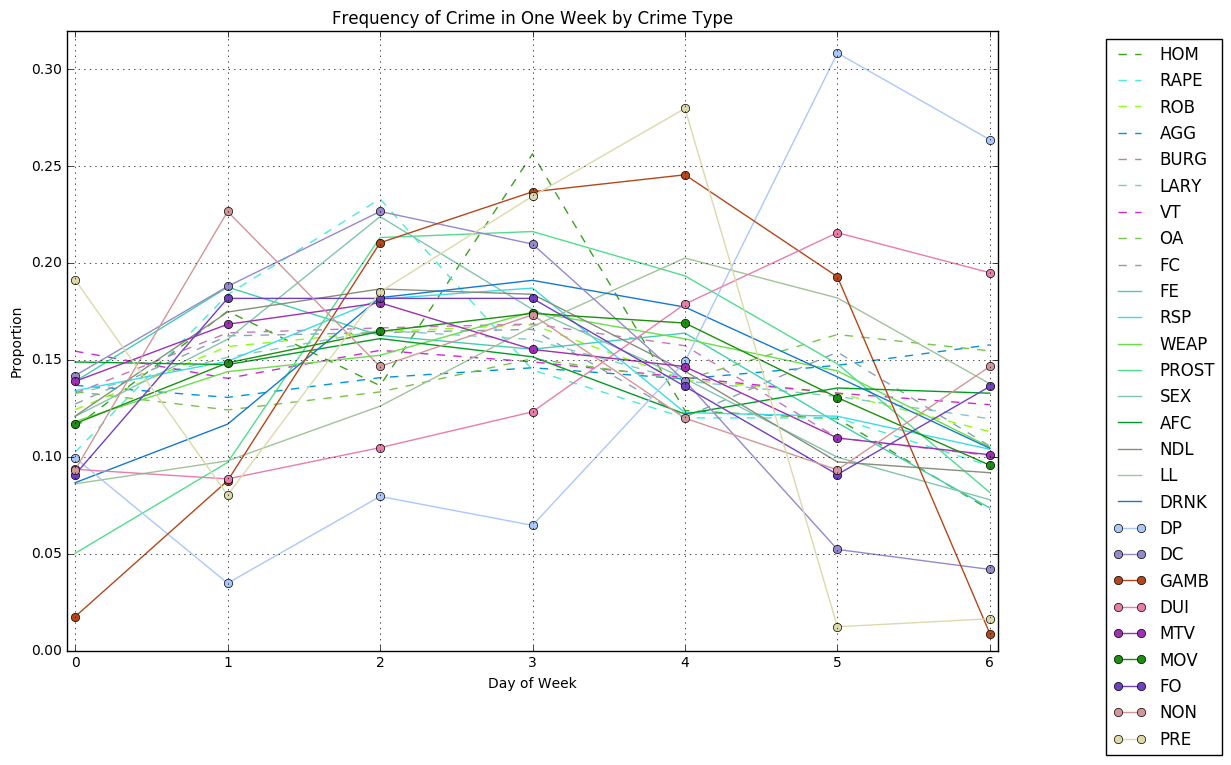

In [31]:
Plot_Week = pd.DataFrame(columns = Abbr[1:])
for i in range(1,28):
    col = []
    a = Arrest[Arrest['CHRG_GRP_CD'] == i]
    for j in range(0,7):
        b = a[a['DayOfWeek'] == str(j)]
        col.append(len(b)/Frequency[i-1])
    Plot_Week[Abbr[i]] = col

plt.figure(figsize=(12,8))
plt.title('Frequency of Crime in One Week by Crime Type')
for i in range(1,28):
    rand = np.random.random_sample(3)
    if(i <= 9):
        plt.plot(Plot_Week[Abbr[i]], '--', label = Abbr[i] , color = [rand[0],rand[1],rand[2]])
    elif((i > 9) & (i <= 18)):
        plt.plot(Plot_Week[Abbr[i]], '-', label = Abbr[i] , color = [rand[0],rand[1],rand[2]])
    elif(i > 18):
        plt.plot(Plot_Week[Abbr[i]], '-o', label = Abbr[i] , color = [rand[0],rand[1],rand[2]])
    
plt.xlabel('Day of Week')
plt.ylabel('Proportion')
plt.axis([-0.05,6.05,0,0.32])
plt.legend(bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

The plot above merely provides an overview and formal statistical analysis is required for validation. Assuming the proportion of crimes on weekend equals to 2/7(0.2857), a chi-squared test for the proportion of crimes is constructed below. After adjusting for multiple comparisons, p-values greater than or equal to 0.0019 will be considered significant. The test suggests that the following crimes are more often on weekdays:

Robbery, Burglary, Larceny, Fraud/Embezzlement, Weapon (carry/poss), Prostitution/Allied, Sex(except rape/prst), Narcotic Drug Laws, Drunkness, Disorderly Conduct, Moving Traffic Violations, Miscellaneous Other Violations, and Pre-Delinquency.

And crimes that are more often on weekends are Aggravated Assaults, Other Assaults, Liquor Laws, Distrubing the Peace, and Driving Under Influence. For the remaining crime types there is no significant difference in crime rate on weekdays and weekends.

In [32]:
import statsmodels as stats
Weekend_Prop = 2/7
WeekDF = pd.DataFrame(columns = ['Crimes' , 'Weekday', 'Weekend'])
WeekDF['Crimes'] = Abbr[1:]
WeekDF['Total'] = CrimeTable['Frequency'][0:27]
for i in range(1,28):
    a = Arrest[Arrest['CHRG_GRP_CD'] == i]
    Weekend = len(a[(a['DayOfWeek'] == '5') | (a['DayOfWeek'] == '6')])
    Weekday = len(a) - Weekend
    WeekDF.set_value((i-1), 'Weekday', Weekday)
    WeekDF.set_value((i-1), 'Weekend', Weekend)

ChiSquareTable = pd.DataFrame(columns = ['Crimes', 'Weekday', 'Weekend', 'Proportion on weekend', 'Chi-Square Statistic', 'P-value'])
ChiSquareTable['Crimes'] = Abbr[1:]
ChiSquareTable['Weekday'] = WeekDF['Weekday']
ChiSquareTable['Weekend'] = WeekDF['Weekend']
ChiSquareTable['Proportion on weekend'] = WeekDF['Weekend'] / WeekDF['Total']

for i in range(0,27):
    Total = WeekDF['Weekday'][i] + WeekDF['Weekend'][i]
    ChiSquareTest = stats.stats.proportion.proportions_chisquare([WeekDF['Weekend'][i], Total*Weekend_Prop], [Total,Total], Weekend_Prop)
    ChiSquareTable.set_value(i, 'Chi-Square Statistic', ChiSquareTest[0])
    ChiSquareTable.set_value(i, 'P-value', ChiSquareTest[1])
    
table_5 = FF.create_table(ChiSquareTable)
py.iplot(table_5, filename='pandas_table')

## Time vs Crime
It is also expected that crime frequencies are related to time. Intuitively, Burglary, Larceny, and Moving Traffic Violations should occur more often during working hours, while Prostitution and Rape occur more often during midnight. The crime types are divided into three different groups according to proportion and therefore three plots will be shown.

In [33]:
Arrest_Time = Arrest
Plot_Time = pd.DataFrame(columns = Abbr[1:])
Total_Time = np.asarray(Arrest_Time.groupby(by = ['TIME'])['RPT_ID'].nunique())

for i in range(1,28):
    Col = []
    a = Arrest_Time[Arrest_Time['CHRG_GRP_CD'] == i]
    for j in range(0,24):
        b = a[a['TIME'] == j]
        Col.append(len(b)/Total_Time[j])
    Plot_Time[Abbr[i]] = Col
    
group1,group2,group3 = ([] for i in range(3))
for i in range(1,28):
    a = Plot_Time[Abbr[i]].mean()
    if(a >= 0.004) & (a <= 0.023):
        group1.append(i)
    elif(a > 0.023) & (a <= 0.05):
        group2.append(i)
    elif(a > 0.05):
        group3.append(i)

It can be seen that Burglary has a spike from 3AM to 6AM, while Robbery occurs a little more often during daytime. Pre-Deliquency remains close to 0 except from 7AM to 2PM, which is not surprising since it is the school hours for young people. There is no obvious trend for other crime types in group 1.

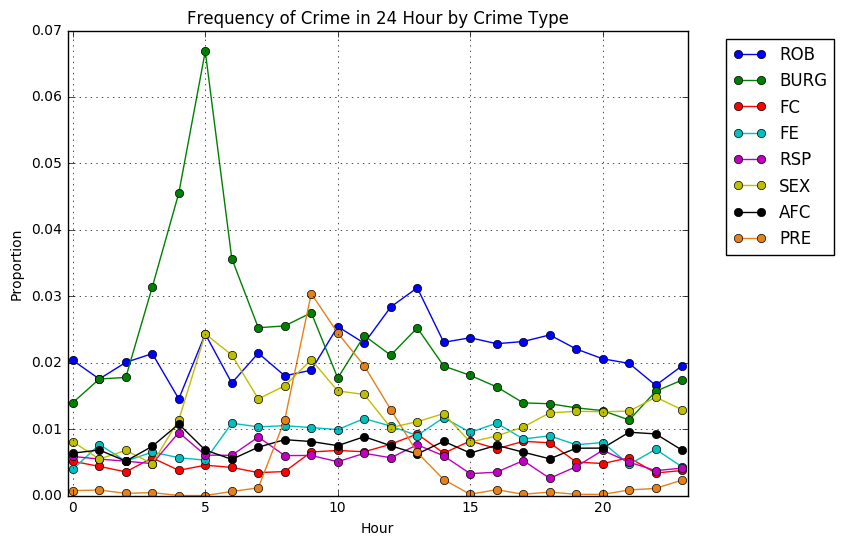

In [34]:
plt.figure(figsize=(8,6))
plt.title('Frequency of Crime in 24 Hour by Crime Type')
for i in group1[0:7]:
    plt.plot(Plot_Time[Abbr[i]], '-o', label = Abbr[i])

plt.plot(Plot_Time[Abbr[27]], '-o', label = Abbr[27], color = [0.9,0.5,0.1])
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.axis([-0.2,23.2,0,0.07])
plt.legend(bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

Disorderly Conduct has an extreme spike from 5AM to 11AM, it is difficult to anticipate the reason for such spike since there are many different kinds of disorderly conduct activities. Larceny and Moving Traffic Violations both see an upward trend during daytime. It is intuitive that Prostitution has a spike around 5AM and low proportion during daytime. 

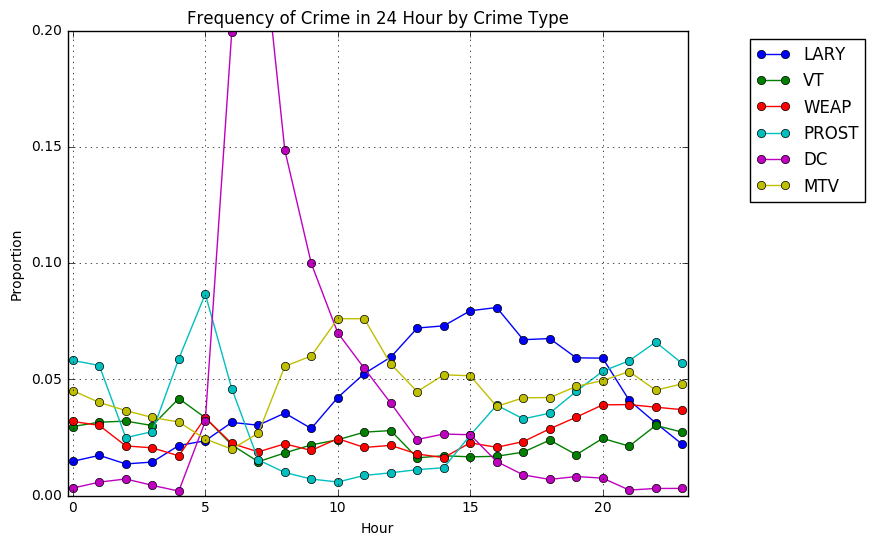

In [35]:
plt.figure(figsize=(8,6))
plt.title('Frequency of Crime in 24 Hour by Crime Type')
for i in group2:
    plt.plot(Plot_Time[Abbr[i]], '-o', label = Abbr[i])
    
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.axis([-0.2,23.2,0,0.2])
plt.legend(bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

Driving Under Influence also has a huge spike at midnight, then the proportion remains very low until around evening. Liquor Laws, Narcotic Drug Laws, and Drunkness all see an upward trend at afternoon. Lastly, Miscellaneous Other Violations has higher proportion from 5AM to 1PM, presumably due to the fact that most people are starting their daily activities.

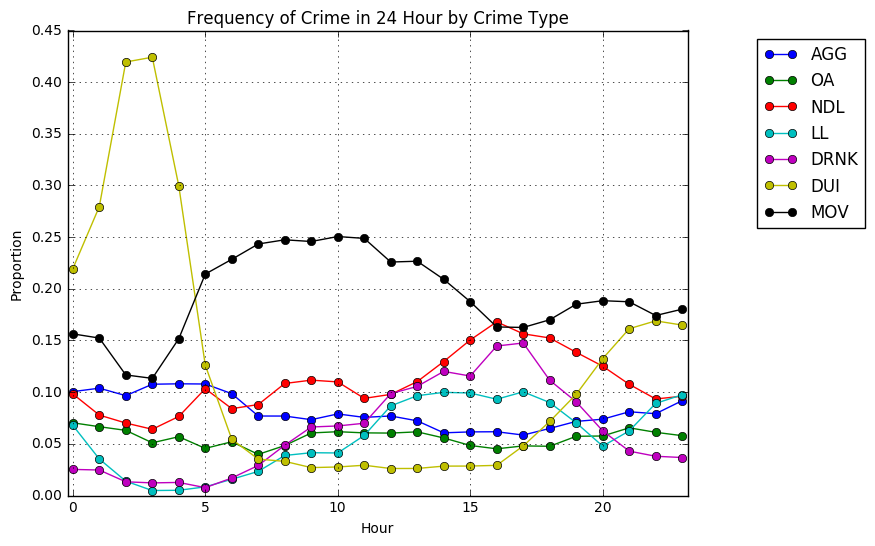

In [36]:
plt.figure(figsize=(8,6))
plt.title('Frequency of Crime in 24 Hour by Crime Type')
for i in group3:
    plt.plot(Plot_Time[Abbr[i]], '-o', label = Abbr[i])
    
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.axis([-0.2,23.2,0,0.45])
plt.legend(bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

Below is a 24-hour crime frequencies plot by day of the week. Sundays and Saturdays have lower crime frequencies during daytime, while Wednesdays and Thursdays have higher crime frequencies during the daytime. The peak among all days and times occurs on Friday 9PM to 12PM, where the difference from the second highest frequency is approximately 200 per hour. One last trend to note is that crime frequencies during midnight appear to be much higher for weekends.

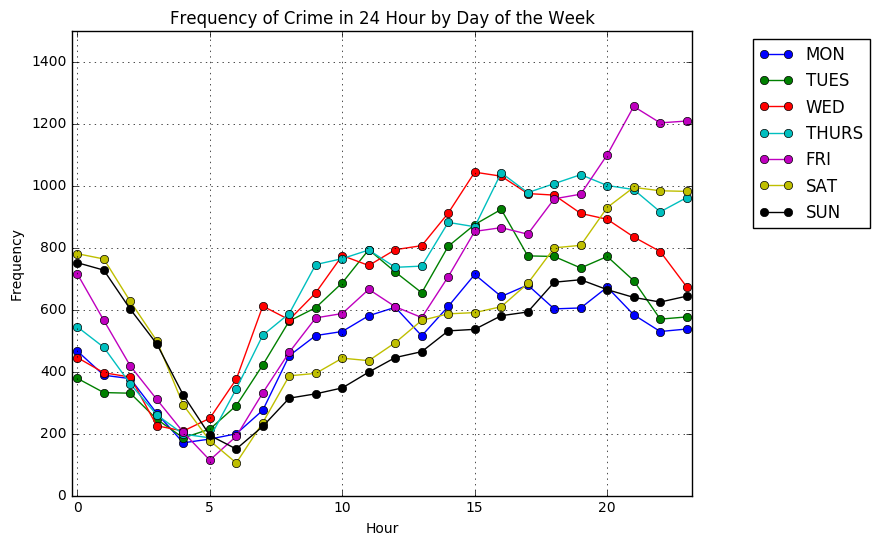

In [37]:
DayCol2 = DayCol+['SUN']
Arrest_Time['TIME'].apply(int)
Plot_Week = pd.DataFrame(columns = DayCol)

for i in range(0,7):
    col = []
    a = Arrest_Time[Arrest_Time['DayOfWeek'] == str(i)]
    for j in range(0,24):
        b = a[a['TIME'] == j]
        col.append(len(b))
    Plot_Week[DayCol2[i]] = col

plt.figure(figsize=(8,6))
plt.title('Frequency of Crime in 24 Hour by Day of the Week')
for i in range(0,7):
    plt.plot(Plot_Week[DayCol2[i]], '-o', label = DayCol2[i])
    
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.axis([-0.2,23.2,0,1500])
plt.legend(bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

It is reasonable to assume that holidays can also affect crime frequencies, since each holiday is celebrated differently and by different group of people. Only Monday holidays such as Martin Luther King, Jr. Day, President’s Day,
Memorial Day, and Labor Day are considered in this case and it is founded that these holidays have more crimes than regular Mondays on average. 

The plot below shows the 24-hour crime proportion comparing Sundays, regular Mondays, and holiday Mondays. One of the interesting trends is the relatively low crime frequencies during holiday Monday working hours(9AM to 12PM), this makes sense because most people do not have to work or go to school on holidays. The other interesting trend is the rapidly increase crime rate near end of the day on holiday Mondays. 

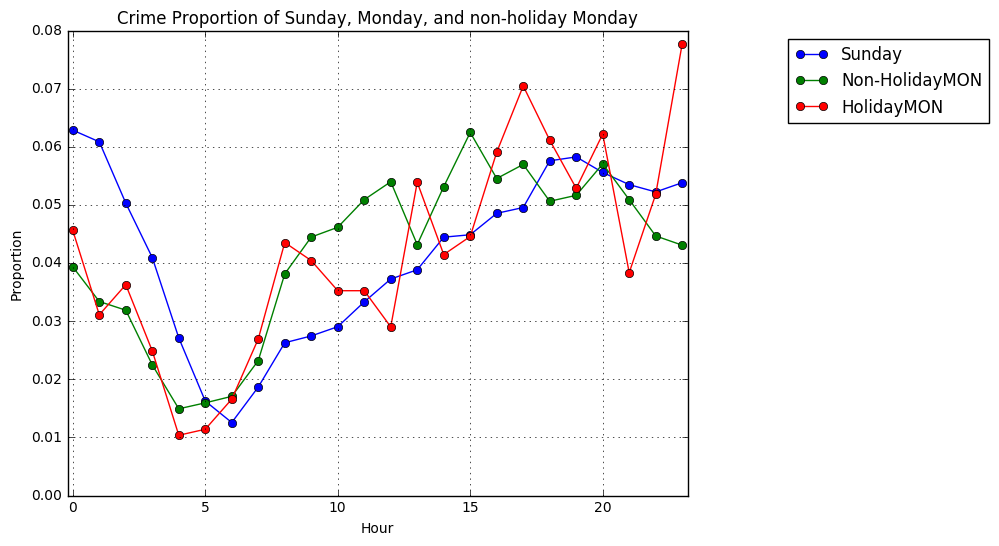

In [38]:
Cols = ['Sunday', 'Non-HolidayMON', 'HolidayMON']
HolidayCompare = pd.DataFrame(columns = Cols)
HoliMonday = pd.DataFrame(columns = Arrest.columns.values)
days = ["2015-01-19", "2015-02-16", "2015-05-25", "2015-09-07"]
Sunday = Arrest[Arrest['DayOfWeek'] == '6']
Monday = Arrest[Arrest['DayOfWeek'] == '0']

for i in days:
    a = Arrest[Arrest['ARST DATE'] == i]
    HoliMonday = pd.merge(HoliMonday, a, how = 'outer')
    Monday = Monday[Monday['ARST DATE'] != i]

Sun_Prop = []
Mon_Prop = []
Holi_Prop = []
for i in range(0,24):
    Sun = Sunday[Sunday['TIME'] == i]
    Sun = len(Sun)/len(Sunday)
    Sun_Prop.append(Sun)
    Mon = Monday[Monday['TIME'] == i]
    Mon = len(Mon)/len(Monday)
    Mon_Prop.append(Mon)
    Holi = HoliMonday[HoliMonday['TIME'] == i]
    Holi = len(Holi)/len(HoliMonday)
    Holi_Prop.append(Holi)
HolidayCompare['Sunday'] = Sun_Prop
HolidayCompare['Non-HolidayMON'] = Mon_Prop
HolidayCompare['HolidayMON'] = Holi_Prop

plt.figure(figsize=(8,6))
plt.title('Crime Proportion of Sunday, Monday, and non-holiday Monday')
for i in range(0,3):
    plt.plot(HolidayCompare[Cols[i]], '-o', label = Cols[i])
    
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.axis([-0.2,23.2,0,0.08])
plt.legend(bbox_to_anchor=(1.5, 1))
plt.grid(True)
plt.show()

# US Census

The following table is constructed using data from Census Reporter regarding ethnic background and gender information of overall population of City of Los Angeles in 2015. The gender ratio of overall population is approximately the same and about half of the population in Ciy of Los Angeles are Hispanic descents. From the arrest per 1000 people(Male vs Female) it appears that males are more likely to be arrested than females, considering that the gender ratio is almost the same.

In [39]:
Ethnicity = ['Asian', 'Black', 'Hispanic', 'Other', 'White']
EthnicProp = [0.11,0.09,0.49,0.03,0.28]
Total = 3971896
Male = int(Total*0.49)
Female = Total - Male
Demographic = pd.DataFrame(columns = ['Description'] + Ethnicity)
Demographic['Description'] = ['Population', 'Population Proportion', 'Male_Total', 'Female_Total', 'Arrests', 'Male_Arrests',
                              'Female_Arrests', 'Arrests per 1000(Male)', 'Arrests per 1000(Female)']
for i in range(0,5):
    Population = int(Total * EthnicProp[i])
    Demographic[Ethnicity[i]].iloc[0] = Population 
    Demographic[Ethnicity[i]].iloc[1] = EthnicProp[i]
    Demographic[Ethnicity[i]].iloc[2] = int(Male*EthnicProp[i])
    Demographic[Ethnicity[i]].iloc[3] = Population - int(Male*EthnicProp[i])
    EthicArrests = Arrest[Arrest['DESCENT_CD'] == Ethnicity[i][0]]
    Demographic[Ethnicity[i]].iloc[4] = len(EthicArrests)
    Demographic[Ethnicity[i]].iloc[5] = len(EthicArrests[EthicArrests['SEX_CD'] == "M"])
    Demographic[Ethnicity[i]].iloc[6] = len(EthicArrests[EthicArrests['SEX_CD'] == "F"])
    Demographic[Ethnicity[i]].iloc[7] = len(EthicArrests[EthicArrests['SEX_CD'] == "M"])/Male*1000
    Demographic[Ethnicity[i]].iloc[8] = len(EthicArrests[EthicArrests['SEX_CD'] == "F"])/Female*1000
    
Demographic

,Description,Asian,Black,Hispanic,Other,White
0,Population,436908,357470,1946229,119156,1112130
1,Population Proportion,0.11,0.09,0.49,0.03,0.28
2,Male_Total,214085,175160,953652,58386,544944
3,Female_Total,222823,182310,992577,60770,567186
4,Arrests,508,29904,47687,5325,17725
5,Male_Arrests,291,22530,40109,4020,13023
6,Female_Arrests,217,7374,7578,1305,4702
7,Arrests per 1000(Male),0.14952,11.5762,20.6086,2.06553,6.6914
8,Arrests per 1000(Female),0.107125,3.64028,3.74099,0.644232,2.32121


In the dataset, there are 79973 male arrests and 21176 female arrests, even though the gender ratio of overall population is approximately 50:50. For every 1000 males there are 41 male arrests and 11 female arrests for every 1000 females. A chi-squared test for difference in proportion is shown below for each crime type and it is evident that males are more likely to be arrested than females.

It is also true that certain gender is more likely to commit certain crimes. Most crime types have a higher male counts and the top three crime types with the highest male proportion are Rape, Homicide, and Weapon (carry/poss). Federal Offense has very high male proportion but only 1 female count, which makes the chi-squared test invalid. However, despite males are more likely to commit crimes in general, females are more likely to commit Prostitution/Allied and Non-criminal Detention.

In [40]:
import statsmodels as stats
Gender_Prop = 1/2
Gender = pd.DataFrame(columns = ['Crimes' , 'Male', 'Female', 'Total'])
Gender['Crimes'] = Abbr[1:]
Gender['Total'] = CrimeTable['Frequency'][0:27]
for i in range(1,28):
    a = Arrest[Arrest['CHRG_GRP_CD'] == i]
    Male = len(a[(a['SEX_CD'] == "M")])
    Female = len(a) - Male
    Gender.set_value((i-1), 'Male', Male)
    Gender.set_value((i-1), 'Female', Female)

ChiSquareTable_Gender = pd.DataFrame(columns = ['Crimes', 'Male', 'Female', 'Male Proportion', 'Chi-Square Statistic', 'P-value'])
ChiSquareTable_Gender['Crimes'] = Abbr[1:]
ChiSquareTable_Gender['Male'] = Gender['Male']
ChiSquareTable_Gender['Female'] = Gender['Female']
ChiSquareTable_Gender['Male Proportion'] = Gender['Male'] / Gender['Total']

for i in range(0,27):
    Total = Gender['Total'][i]
    ChiSquareTest_Gender = stats.stats.proportion.proportions_chisquare([Gender['Male'][i], Total*Gender_Prop], [Total,Total], Gender_Prop)
    ChiSquareTable_Gender.set_value(i, 'Chi-Square Statistic', ChiSquareTest_Gender[0])
    ChiSquareTable_Gender.set_value(i, 'P-value', ChiSquareTest_Gender[1])
    
table_6 = FF.create_table(ChiSquareTable_Gender)
py.iplot(table_6, filename='pandas_table')

Crime rates can also vary for different ethnicities, a table is constructed below showing frequencies for each crime type commited by different ethnicities. The summary for the five main ethnicities are as the follows:

    For every 1000 ethnic Asians, there are about 1.2 arrests 

    For every 1000 ethnic Blacks, there are about 83.7 arrests. 

    For every 1000 ethnic Hispanics, there are about 44.7 arrests

    For every 1000 ethnic Others, there are about 15.9 arrests. 

    For every 1000 ethnic Whites, there are about 15.9 arrests. 

Asian people have lowest crime counts among all crime types, but the abnormally low crime counts seem questionable. The categorization performed while cleaning the dataset has considered most of the possible Asian ethnicities, so the reason for this occurrence might have to do with the portion of the dataset containing missing crime codes. However, an analysis of crime types on that dataset is difficult without crime codes.

Among most of the crime types, Black people have higher counts than people of other descents, except for Rape, Forgery/Counterfeit, Fraud/Embezzlement, Receive Stolen Property, Distrubing the Peace, Gambling, Driving Under Influence, Federal Offenses, and Pre-Deliquency.

In [41]:
EthnicCount = pd.DataFrame(columns = ['Crimes', 'Asian', 'Black', 'Hispanic', 'Other', 'White', 'Total'])
EthnicCount['Crimes'] = Abbr[1:]
for i in range(1,28):
    col = []
    a = Arrest[Arrest['CHRG_GRP_CD'] == i]
    EthnicCount.set_value((i-1), 'Total', len(a))
    for j in range(0,5):
        b = a[a['DESCENT_CD'] == Ethnicity[j][0]]
        EthnicCount[Ethnicity[j]][(i-1)] = len(b)
        
for i in range(0,5):
    newcol = Ethnicity[i]+ ' Per 1000'
    EthnicCount[newcol] = EthnicCount[Ethnicity[i]]/Demographic[Ethnicity[i]][0]*1000

EthnicCount

,Crimes,Asian,Black,Hispanic,Other,White,Total,Asian Per 1000,Black Per 1000,Hispanic Per 1000,Other Per 1000,White Per 1000
0,HOM,0,83,123,9,19,234,0,0.232187,0.0631991,0.0755312,0.0170843
1,RAPE,0,62,159,23,39,283,0,0.173441,0.0816964,0.193024,0.0350678
2,ROB,0,1029,948,57,177,2211,0,2.87856,0.487096,0.478364,0.159154
3,AGG,15,2306,3975,472,1081,7849,0.0343322,6.45089,2.04241,3.96119,0.972009
4,BURG,0,734,840,89,294,1957,0,2.05332,0.431604,0.74692,0.264358
5,LARY,23,1662,1846,312,1020,4863,0.0526427,4.64934,0.948501,2.61842,0.917159
6,VT,3,655,1335,85,277,2355,0.00686643,1.83232,0.685942,0.713351,0.249072
7,OA,7,1799,2660,328,912,5706,0.0160217,5.03259,1.36675,2.75269,0.820048
8,FC,6,139,273,60,119,597,0.0137329,0.388844,0.140271,0.503542,0.107002
9,FE,7,196,326,95,218,842,0.0160217,0.548298,0.167503,0.797274,0.19602


# Wrap Up
It is no secret that young people are much more likely to commit crimes, since people who are between 24 to 45 years old are responsible for half of the total crimes. Each arrest incident should be assigned a crime code for justification purposes, the fact that approximately 11% of arrests were made without proper description is something to be concerned about. 

For most crime types, both the Linear and Poisson models suggest decreases in frequency over the year, except for Aggravated Assault, Vehicle Theft, Other Assaults, Against Family/Child, and Disorderly Conduct. Despite each crime has its own trend, day of the week is an excellent predictor for crime counts. Certain crimes such as Robbery and Burglary tend to happen on weekdays, while Distrubing the Peace and Driving Under Influence tend to happen on weekends.

Many of the crimes have a much larger male perpetrator proportion, but females are more likely to be arrested for Prostitution/Allied and Non-criminal Detention. Each ethnicity has varying crime frequency trends, but it is reasonable to claim that people of certain ethnicity are more likely to commit certain crimes than people of other ethnicities.